In [25]:
from pathlib import Path
import sys
if str(Path.cwd().parent) not in sys.path:
    sys.path.append(str(Path.cwd().parent))
from os import listdir
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cycler
import os
from utils.preprocessing import rename_aper
from astroML.datasets import fetch_sdss_spectrum
from settings.paths import match_path, img_path
from astroquery.sdss import SDSS
from astropy import coordinates as coords
from astropy import units as u
from astropy.table import Table
from glob import glob
n = 12
color = plt.cm.jet(np.linspace(0, 1,n))
plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
plt.rcParams["font.size"] = 22

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
AB2flux(21,6600)

NameError: name 'AB2flux' is not defined

In [ ]:
def AB2flux(mag,wav):
    try:
        if len(mag)>1:
            mag = np.array(mag)
            print(mag)
    except:
        pass

    fv = -(mag+48.60)/2.5
    fv = 10**fv
    c = 3*10e10
    fv = c*fv/(wav**2)
    return fv


In [ ]:
import astropy.units as u
from astropy import uncertainty as unc
mag = 21

In [ ]:
lam = 5500 * u.AA
fnu = (21*u.ABmag).to(u.erg/u.s/u.cm**2/u.AA, u.spectral_density(lam))

In [ ]:
fnu

<Quantity 1.43250229e-17 erg / (Angstrom cm2 s)>

In [7]:
fnu.value

NameError: name 'fnu' is not defined

In [8]:
AB2flux(21,5500)

NameError: name 'AB2flux' is not defined

In [9]:
def AB2flux(mag,wav):
    try:
        if len(mag)>1:
            mag = np.array(mag)
    except:
        pass
    lam = wav * u.AA
    fv = (mag*u.ABmag).to(u.erg/u.s/u.cm**2/u.AA, u.spectral_density(lam))
    fv = fv.value
    # fv = -(mag+2.41)/2.5
    # fv = 10**fv
    # fv = fv/(wav**2)
    return fv

def e_AB2flux(mag,sn, wav):
    try:
        if len(sn)>1:
            sn = np.array(sn)
    except:
        pass

    fv = AB2flux(mag,wav)
    # error = error*np.log(10)*fv #acho que ta errado
    # exp = 10**(-2.41/2.5)
    # error_fv = error*np.log(10)*fv*exp  #ta errado ainda
    error_fv = fv/sn
    return error_fv

In [10]:
aper = "PStotal"
features =  {'u_'+aper: 3536,
'J0378_'+aper: 3770,
'J0395_'+aper: 3940,
'J0410_'+aper: 4094,
'J0430_'+aper: 4292,
'g_'+aper: 4751,        
'J0515_'+aper: 5133,
'r_'+aper: 6258,  
'J0660_'+aper: 6614,
'i_'+aper: 7690,    
'J0861_'+aper: 8611,
'z_'+aper: 8831}

In [11]:
table = pd.read_table(os.path.join(match_path,"STRIPE82_DR2_DR16Q1a_unWISE2a_GALEXDR672a.csv"), sep=",")
table = rename_aper(table)

/tmp/ipykernel_49004/3810317677.py:1: DtypeWarning: Columns (432,599,603,604) have mixed types. Specify dtype option on import or set low_memory=False.
  table = pd.read_table(os.path.join(match_path,"STRIPE82_DR2_DR16Q1a_unWISE2a_GALEXDR672a.csv"), sep=",")


In [12]:
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import ScalarFormatter
class ScalarFormatterForceFormat(ScalarFormatter):
    def _set_format(self):  # Override function that finds format to use.
        self.format = "%1.1f"  # Give format here

def plot_SED(cand, stamp = False, save=False):
    
    if stamp:
        fig, [ax,ax2] = plt.subplots(1, 2 , figsize=(1,6))
    else:
        fig, ax = plt.subplots(1, 1, figsize=(11,5))
    
    # SDSS spectra
    try:
        pos = coords.SkyCoord(cand.RA_1*u.degree,cand.DEC_1*u.degree, frame='icrs')
        xid = SDSS.query_region(pos, spectro=True)
        sp = SDSS.get_spectra(matches=xid)
    except:
        print("Couldn't find spectrum.")
        pass
    try:
        # print(Table(sp[0][3].data))
        print(sp[0][0].header["PLATEID"], sp[0][0].header["MJD"],sp[0][0].header["FIBERID"])
        spec = Table(sp[0][1].data).to_pandas()
        ax.plot(10**spec.loglam, 1e-17*spec.flux, '-' , color='lightgray', zorder=0)
    except:
        pass

    # S-PLUS SED
    feat = []
    wav = []
    sed = []

    for key,value in features.items():
        feat.append(key)
        wav.append(value)
        sed.append(AB2flux(cand[key], value))
    # Plotting curve
    ax.plot(wav, sed , 'k--')

    # Plotting errors (non functional)
    for key,value in features.items():
        ax.errorbar(value, AB2flux(cand[key], value), yerr = e_AB2flux(cand[key], cand["s2n_"+key], value), fmt = '-o')

    # Plotting markers
    for key,value in features.items():   
        if key[0] != "J":
            marker = "s"
        else:
            marker = "^"
        
        ax.scatter(value, AB2flux(cand[key], value), s=200, marker=marker)
        if cand["e_"+key] > 0.5 or cand[key]==99:
            # Empty marker for high magnitude error or non-detection
            ax.scatter(value, AB2flux(cand[key], value), s=40, marker=marker, color="white", zorder=10000)

    # Plot stamp
    if stamp:
        img = conn.get_img(cand.RA,cand.DEC, R="I", G="R", B="G", stretch=0.5, Q=5, radius = 200)
        ax2.imshow(img)
        ax2.axes.get_xaxis().set_visible(False)
        ax2.axes.get_yaxis().set_visible(False)
        ax2.set_title('RA  ' +  str(np.round(cand.RA,2))+'     DEC  '+ str(np.round(cand.DEC,2))+ '\n r  '+ str(np.round(cand.r_PStotal,3))+ '\n Spectral Type (SDSS): ' + cand.subClass)
    
    # Plot emission lines from SDSS spectra
    try:
        for id, row in Table(sp[0][3].data).to_pandas().iterrows():
            lambda_obs = row.LINEZ*row.LINEWAVE+row.LINEWAVE
            if row.LINECHI2 != -1. and lambda_obs < 9000 and row.LINENAME[:3]!="N_V":
                ax.axvline(lambda_obs, linestyle="dashed", alpha=0.5, color="steelblue")
                trans = ax.get_xaxis_transform()
                plt.text(lambda_obs-150, 0.65, row.LINENAME, transform=trans, rotation=90, fontsize = 14)
    except:
        pass

    # Plot redshi[ft at top left border
    if cand.Z < 3:
        plt.text(0.80, 0.7, "z = "+str(np.round(cand.Z,3))+"\n r = "+str(np.round(cand.r_PStotal,1)),transform = ax.transAxes, bbox=dict(facecolor='lightgray', alpha=0.2))
    else:
        plt.text(0.05, 0.7, "z = "+str(np.round(cand.Z,3))+"\n r = "+str(np.round(cand.r_PStotal,1)),transform = ax.transAxes, bbox=dict(facecolor='lightgray', alpha=0.2))
    
    # ax.set_ylabel(r'Flux [erg s$^{-1}$ cm$^{-2}$ Hz$^{-1}$]')
    ax.set_ylabel(r'Flux [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')
    ax.set_xlabel(r'Wavelength ($\AA$)')
    ax = plt.gca()
    yfmt = ScalarFormatterForceFormat()
    yfmt.set_powerlimits((0,0))
    ax.yaxis.set_major_formatter(yfmt)
    # plt.gca().set_xlim(right=9000)
    plt.xlim(3500,9000)
    # plt.ylim(-0.5e-16, 0.5e-16)
    lims = plt.gca().get_xlim()
    try:
        i = np.where( (10**spec.loglam > lims[0]) &  (10**spec.loglam < lims[1]) )[0]
        # plt.gca().set_ylim( 1e-17*spec.flux[i].min()*(0.2), 1e-17*spec.flux[i].max()*1.1 )
        plt.gca().set_ylim(-1e-17, 1e-17*spec.flux[i].max()*1.15 )
        
    except:
        pass
    plt.title("SDSS J%s" % cand.SDSS_NAME)
    plt.tight_layout()

    if save:
        plt.savefig(os.path.join(img_path,'spec_'+str(np.round(cand.RA_1,2))+'-'+str(np.round(cand.DEC_1,2))+'_z='+str(np.round(cand.Z,3))+'.png'))
    plt.show()

In [13]:
def plot_SED_aper(cand,  save=False):

    fig, ax = plt.subplots(1, 1, figsize=(14,6))
    
    try:
        pos = coords.SkyCoord(cand.RA_1*u.degree,cand.DEC_1*u.degree, frame='icrs')
        xid = SDSS.query_region(pos, spectro=True)
        sp = SDSS.get_spectra(matches=xid)
        spec = Table(sp[0][1].data).to_pandas()
        ax.plot(10**spec.loglam, 1e-17*spec.flux, '-' , color='lightgray', zorder=0)
    except:
        pass

    for aper,color in zip(["PStotal", "aper_3", "aper_6", "auto"], ["b", "g","r", "c"]):
        features =  {'u_'+aper: 3536,
        'J0378_'+aper: 3770,
        'J0395_'+aper: 3940,
        'J0410_'+aper: 4094,
        'J0430_'+aper: 4292,
        'g_'+aper: 4751,        
        'J0515_'+aper: 5133,
        'r_'+aper: 6258,  
        'J0660_'+aper: 6614,
        'i_'+aper: 7690,    
        'J0861_'+aper: 8611,
        'z_'+aper: 8831}
        feat = []
        wav = []
        sed = []
        yerror = []
        for key,value in features.items():
            feat.append(key)
            wav.append(value)
            sed.append(AB2flux(cand[key], value))
            yerror.append(e_AB2flux(cand[key], cand["s2n_"+ key], value))
        ax.plot(wav, sed , '--', color=color, label=aper)
        ax.errorbar(wav, sed, yerr=yerror, fmt='-o', color=color)
        # for key,value in features.items():   
        #     ax.scatter(value, AB2flux(cand[key], value), s=100)

    ax.set_ylabel(r'Flux [erg s$^{-1}$ cm$^{-2}$ Hz$^{-1}$]')
    ax.set_xlabel('Wavelength')
    ax.grid()
    plt.legend()
    plt.gca().set_xlim(right=9000)
    lims = plt.gca().get_xlim()
    i = np.where( (10**spec.loglam > lims[0]) &  (10**spec.loglam < lims[1]) )[0]
    plt.gca().set_ylim( 1e-17*spec.flux[i].min(), 1e-17*spec.flux[i].max() )
    plt.tight_layout()
    plt.show()

    if save:
        plt.savefig(os.path.join('..','img','spec_'+str(np.round(cand.RA_1,2))+'-'+str(np.round(cand.DEC_1,2))+'.png'))


In [14]:
# subset = table.query("r_PStotal<21 and ZWARNING==0 and PhotoFlag_r==0").sample(1)
subset = table.iloc[[12084, 3830, 21902, 36825, 7861]]
# subset = table.iloc[[7861]]


In [15]:
table.iloc[[12084, 3830, 21902, 36825, 7861]][["r_PStotal", "RA_1", "DEC_1", "Z", "SDSS_NAME"]]

,r_PStotal,RA_1,DEC_1,Z,SDSS_NAME
12084,18.930698,25.219992,1.028450,1.639318,014052.80+010142.2
3830,19.916765,9.015123,-0.425817,2.238000,003603.63-002533.1
21902,19.752758,310.250609,0.794512,2.516336,204100.14+004740.1
36825,20.604030,356.630106,-0.927636,3.207000,234631.24-005539.5
7861,18.999012,16.580132,0.806495,4.435000,010619.24+004823.3


12084 1.6393176317214966 STRIPE82-0038 25.219991576774436 1.028449956807097
401 51788 368


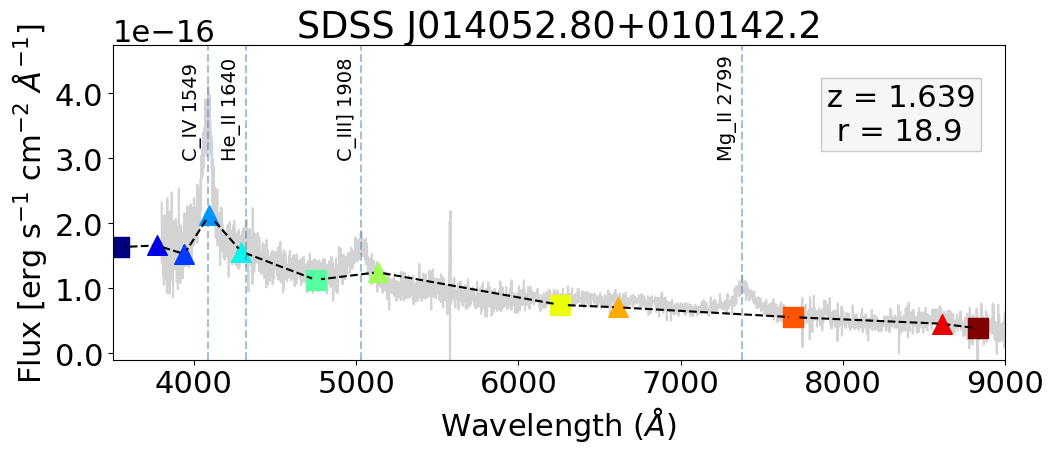

3830 2.238 STRIPE82-0013 9.015123143996409 -0.4258166168611622


/home/mariko/anaconda3/envs/sqg_idr5/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


690 52261 227


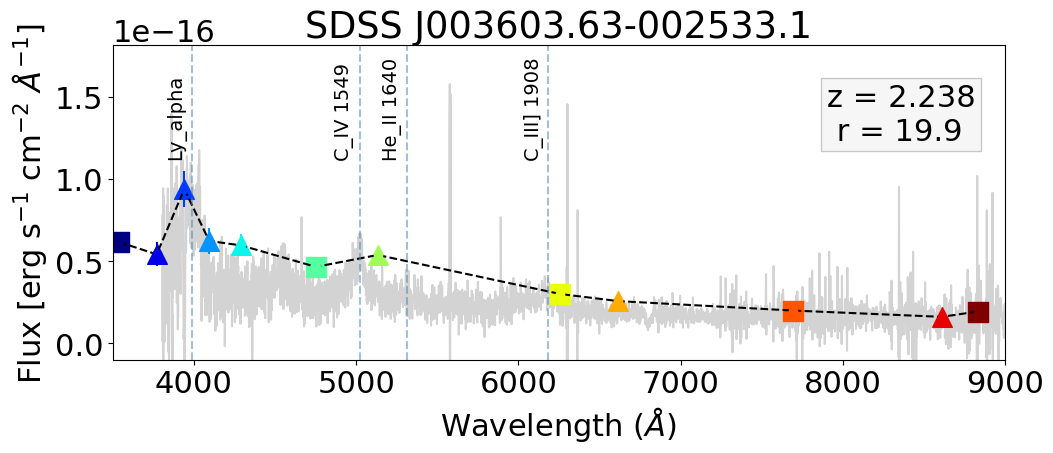

21902 2.516336 STRIPE82-0102 310.250608557188 0.7945122183405389
1117 52885 452


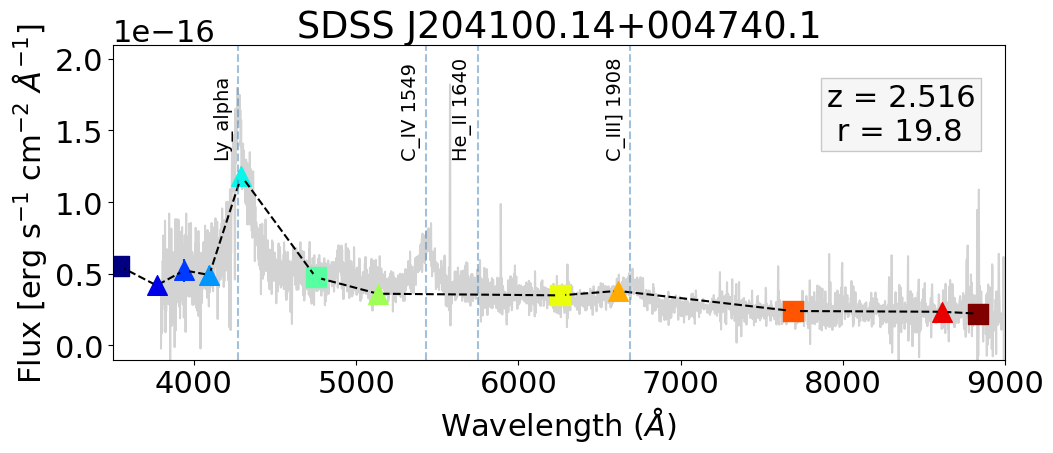

36825 3.207 STRIPE82-0167 356.6301062696892 -0.9276357102057414


/home/mariko/anaconda3/envs/sqg_idr5/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


4214 55451 290


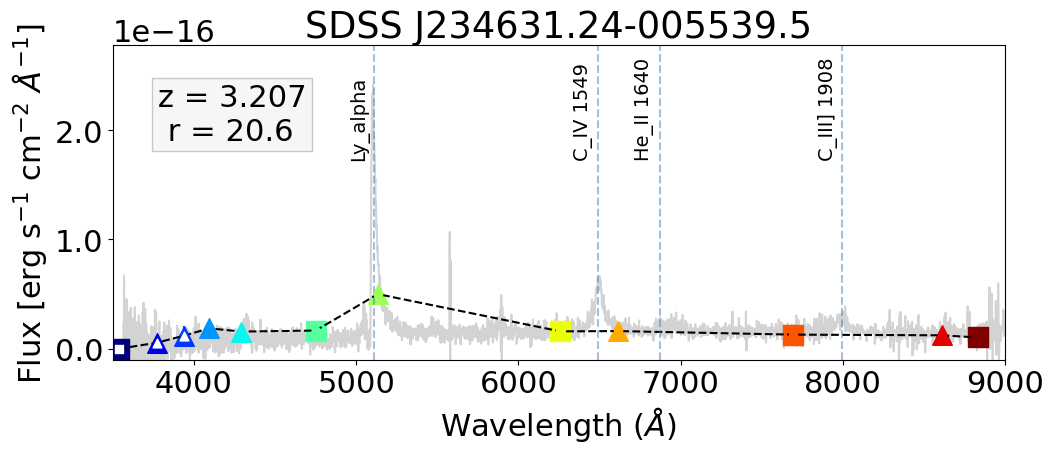

7861 4.435 STRIPE82-0026 16.580131544341818 0.8064950808416276


/home/mariko/anaconda3/envs/sqg_idr5/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


4226 55475 675


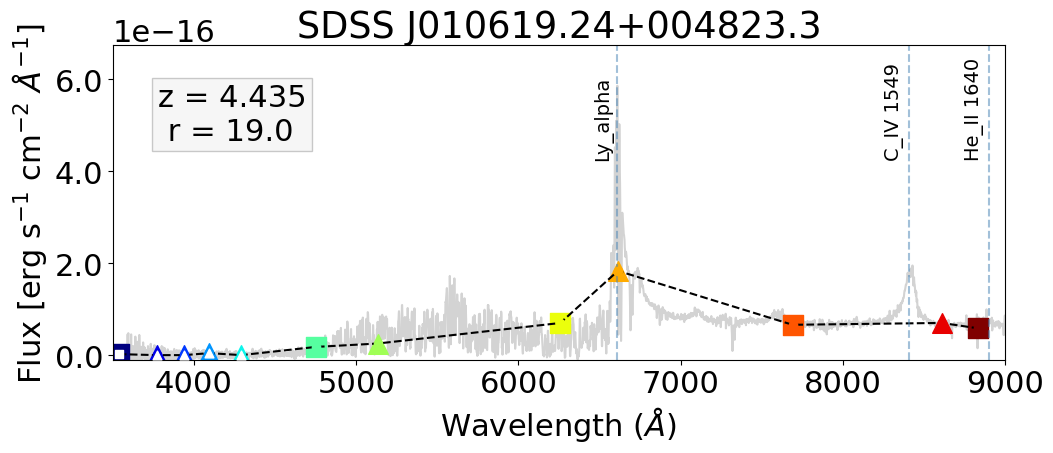

In [20]:
for id, row in subset.iterrows():
    print(id, row.Z, row.Field, row.RA_1, row.DEC_1)
    plot_SED(row, save=True)
    # plot_SED_aper(row)

In [126]:
def plot_SED(cand, stamp = False, save=False):
    
    if stamp:
        fig, [ax,ax2] = plt.subplots(1, 2 , figsize=(1,6))
    else:
        fig, ax = plt.subplots(1, 1, figsize=(12,5))
    
    # SDSS spectra
    try:
        pos = coords.SkyCoord(cand.RA_1*u.degree,cand.DEC_1*u.degree, frame='icrs')
        xid = SDSS.query_region(pos, spectro=True)
        sp = SDSS.get_spectra(matches=xid)
    except:
        print("Couldn't find spectrum.")
        pass
    try:
        # print(Table(sp[0][3].data))
        print(sp[0][0].header["PLATEID"], sp[0][0].header["MJD"],sp[0][0].header["FIBERID"])
        spec = Table(sp[0][1].data).to_pandas()
        ax.plot(10**spec.loglam, 1e-17*spec.flux, '-' , color='lightgray', zorder=0)
    except:
        pass

    # S-PLUS SED
    feat = []
    wav = []
    sed = []

    for key,value in features.items():
        feat.append(key)
        wav.append(value)
        sed.append(AB2flux(cand[key], value))
    # Plotting curve
    # ax.plot(wav, sed , 'k--')

    # Plotting errors (non functional)
    for key,value in features.items():
        ax.errorbar(value, AB2flux(cand[key], value), yerr = e_AB2flux(cand[key], cand["s2n_"+key], value), fmt = '-o')
    
    # Plotting markers
    for key,value in features.items():   
        if key[0] != "J":
            marker = "s"
        else:
            marker = "^"
        
        ax.scatter(value, AB2flux(cand[key], value), s=200, marker=marker)
        if cand["e_"+key] > 0.5 or cand[key]==99:
            # Empty marker for high magnitude error or non-detection
            ax.scatter(value, AB2flux(cand[key], value), s=40, marker=marker, color="white", zorder=10000)

    # Plot stamp
    if stamp:
        img = conn.get_img(cand.RA,cand.DEC, R="I", G="R", B="G", stretch=0.5, Q=5, radius = 200)
        ax2.imshow(img)
        ax2.axes.get_xaxis().set_visible(False)
        ax2.axes.get_yaxis().set_visible(False)
        ax2.set_title('RA  ' +  str(np.round(cand.RA,2))+'     DEC  '+ str(np.round(cand.DEC,2))+ '\n r  '+ str(np.round(cand.r_PStotal,3))+ '\n Spectral Type (SDSS): ' + cand.subClass)
    
    # Plot emission lines from SDSS spectra
    try:
        for id, row in Table(sp[0][3].data).to_pandas().iterrows():
            lambda_obs = row.LINEZ*row.LINEWAVE+row.LINEWAVE
            if row.LINECHI2 != -1. and lambda_obs < 9000 and row.LINENAME[:3]!="N_V":
                ax.axvline(lambda_obs, linestyle="dashed", alpha=0.5, color="steelblue")
                trans = ax.get_xaxis_transform()
                plt.text(lambda_obs-150, 0.65, row.LINENAME, transform=trans, rotation=90, fontsize = 14)
    except:
        pass


    # Plot redshi[ft at top left border
    if cand.Z < 3:
        plt.text(0.80, 0.7, "z = "+str(np.round(cand.Z,3))+"\n r = "+str(np.round(cand.r_PStotal,1)),transform = ax.transAxes, bbox=dict(facecolor='lightgray', alpha=0.2))
    else:
        plt.text(0.05, 0.7, "z = "+str(np.round(cand.Z,3))+"\n r = "+str(np.round(cand.r_PStotal,1)),transform = ax.transAxes, bbox=dict(facecolor='lightgray', alpha=0.2))
    
    # ax.set_ylabel(r'Flux [erg s$^{-1}$ cm$^{-2}$ Hz$^{-1}$]')
    ax.set_ylabel(r'Flux [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')
    ax.set_xlabel(r'Wavelength ($\AA$)')
    ax = plt.gca()
    yfmt = ScalarFormatterForceFormat()
    yfmt.set_powerlimits((0,0))
    ax.yaxis.set_major_formatter(yfmt)
    # plt.gca().set_xlim(right=9000)
    plt.xlim(3500,9000)
    # plt.ylim(-0.5e-16, 0.5e-16)
    lims = plt.gca().get_xlim()
    try:
        i = np.where( (10**spec.loglam > lims[0]) &  (10**spec.loglam < lims[1]) )[0]
        # plt.gca().set_ylim( 1e-17*spec.flux[i].min()*(0.2), 1e-17*spec.flux[i].max()*1.1 )
        plt.gca().set_ylim(-1e-17, 1e-17*spec.flux[i].max()*1.15 )
        
    except:
        pass
    plt.title("SDSS J%s" % cand.SDSS_NAME)
    
    # Plot filter curves
    all_curves = glob(os.path.join("..","utils","filter_curves","*.csv"))
    all_curves = np.sort(all_curves)
    print(all_curves)
    ax_curve = ax.twinx()
    for curve in all_curves:
        data = pd.read_table(curve, sep=",")
        ax_curve.plot(data.iloc[:,0]*10, data.iloc[:,1],  alpha=1, linewidth=0.9)     
    
    ax_curve.set_ylim(0,1)    
    ax_curve.tick_params(left=False, labelleft=False, top=False, labeltop=False,
                   right=False, labelright=False, bottom=False, labelbottom=False)

    plt.tight_layout()


    if save:
        plt.savefig(os.path.join(img_path,'spec_'+str(np.round(cand.RA_1,2))+'-'+str(np.round(cand.DEC_1,2))+'_z='+str(np.round(cand.Z,3))+'.png'))
        plt.savefig(os.path.join(img_path,'spec_'+str(np.round(cand.RA_1,2))+'-'+str(np.round(cand.DEC_1,2))+'_z='+str(np.round(cand.Z,3))+'.eps'), format="eps")
    plt.show()

12084 1.6393176317214966 STRIPE82-0038 25.219991576774436 1.028449956807097
401 51788 368
['../utils/filter_curves/a-uJAVA.csv' '../utils/filter_curves/b-J0378.csv'
 '../utils/filter_curves/c-J0395.csv' '../utils/filter_curves/d-J0410.csv'
 '../utils/filter_curves/e-J0430.csv' '../utils/filter_curves/f-gDSSS.csv'
 '../utils/filter_curves/g-J0515.csv' '../utils/filter_curves/h-rSDSS.csv'
 '../utils/filter_curves/i-J0660.csv' '../utils/filter_curves/j-iSDSS.csv'
 '../utils/filter_curves/k-J0861.csv' '../utils/filter_curves/l-zSDSS.csv']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


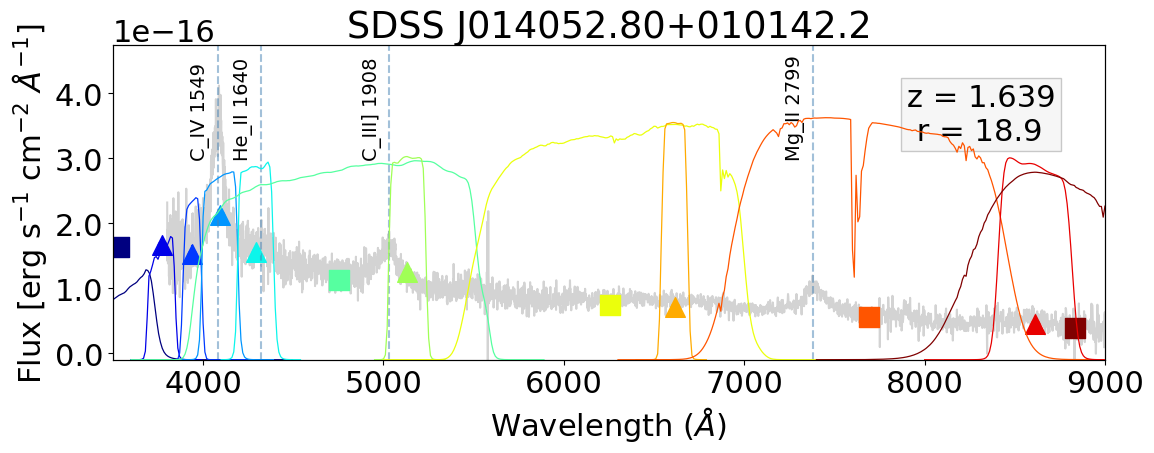

/home/mariko/anaconda3/envs/sqg_idr5/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


3830 2.238 STRIPE82-0013 9.015123143996409 -0.4258166168611622
690 52261 227
['../utils/filter_curves/a-uJAVA.csv' '../utils/filter_curves/b-J0378.csv'
 '../utils/filter_curves/c-J0395.csv' '../utils/filter_curves/d-J0410.csv'
 '../utils/filter_curves/e-J0430.csv' '../utils/filter_curves/f-gDSSS.csv'
 '../utils/filter_curves/g-J0515.csv' '../utils/filter_curves/h-rSDSS.csv'
 '../utils/filter_curves/i-J0660.csv' '../utils/filter_curves/j-iSDSS.csv'
 '../utils/filter_curves/k-J0861.csv' '../utils/filter_curves/l-zSDSS.csv']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


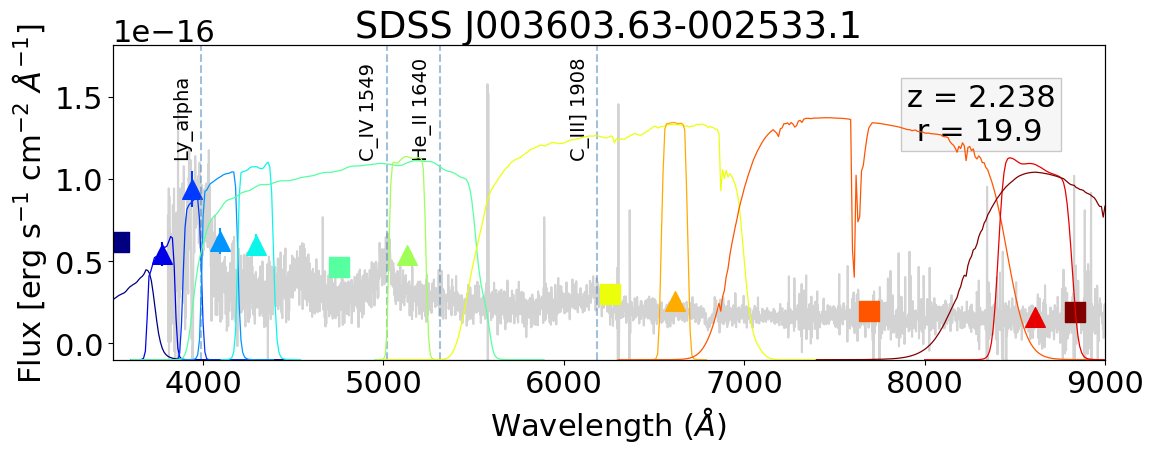

21902 2.516336 STRIPE82-0102 310.250608557188 0.7945122183405389
1117 52885 452
['../utils/filter_curves/a-uJAVA.csv' '../utils/filter_curves/b-J0378.csv'
 '../utils/filter_curves/c-J0395.csv' '../utils/filter_curves/d-J0410.csv'
 '../utils/filter_curves/e-J0430.csv' '../utils/filter_curves/f-gDSSS.csv'
 '../utils/filter_curves/g-J0515.csv' '../utils/filter_curves/h-rSDSS.csv'
 '../utils/filter_curves/i-J0660.csv' '../utils/filter_curves/j-iSDSS.csv'
 '../utils/filter_curves/k-J0861.csv' '../utils/filter_curves/l-zSDSS.csv']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


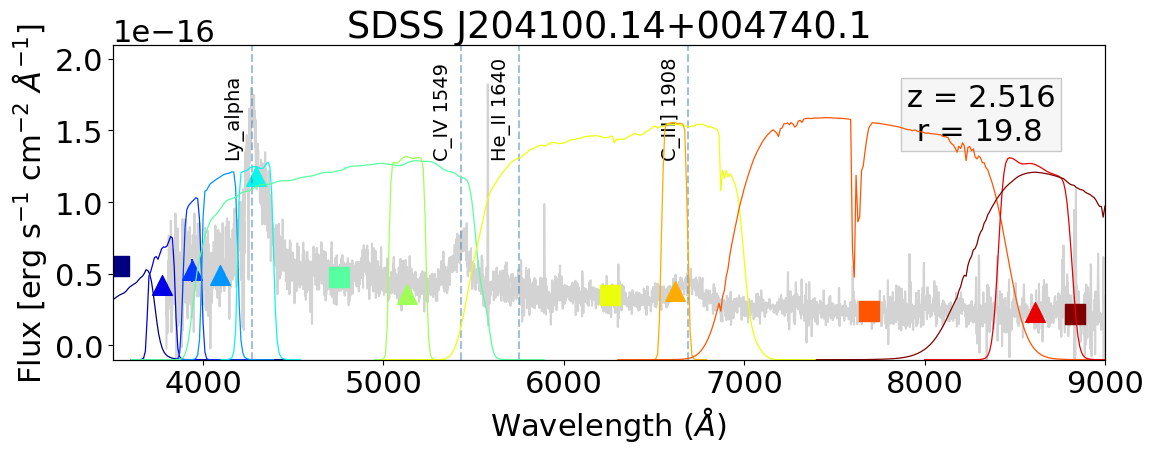

/home/mariko/anaconda3/envs/sqg_idr5/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


36825 3.207 STRIPE82-0167 356.6301062696892 -0.9276357102057414
4214 55451 290
['../utils/filter_curves/a-uJAVA.csv' '../utils/filter_curves/b-J0378.csv'
 '../utils/filter_curves/c-J0395.csv' '../utils/filter_curves/d-J0410.csv'
 '../utils/filter_curves/e-J0430.csv' '../utils/filter_curves/f-gDSSS.csv'
 '../utils/filter_curves/g-J0515.csv' '../utils/filter_curves/h-rSDSS.csv'
 '../utils/filter_curves/i-J0660.csv' '../utils/filter_curves/j-iSDSS.csv'
 '../utils/filter_curves/k-J0861.csv' '../utils/filter_curves/l-zSDSS.csv']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


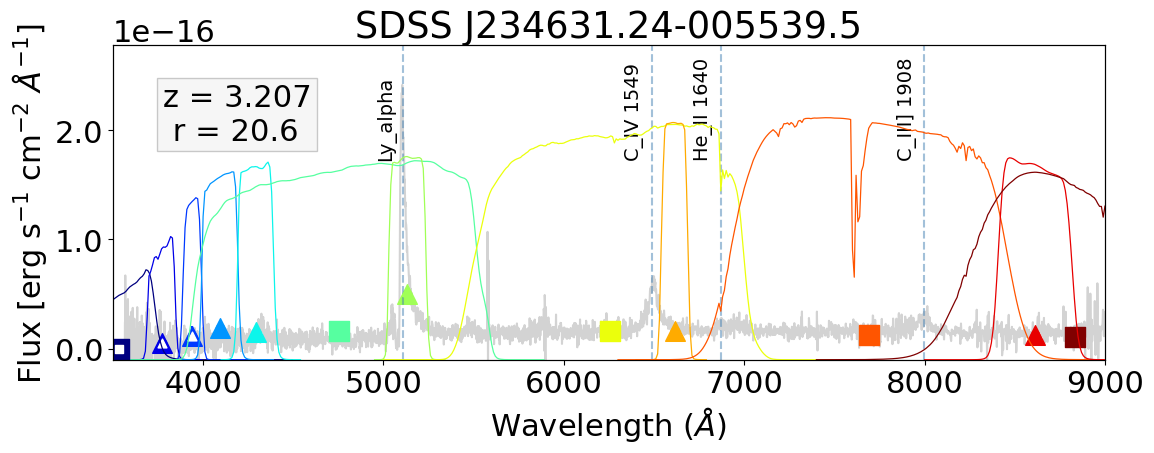

/home/mariko/anaconda3/envs/sqg_idr5/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


7861 4.435 STRIPE82-0026 16.580131544341818 0.8064950808416276
4226 55475 675
['../utils/filter_curves/a-uJAVA.csv' '../utils/filter_curves/b-J0378.csv'
 '../utils/filter_curves/c-J0395.csv' '../utils/filter_curves/d-J0410.csv'
 '../utils/filter_curves/e-J0430.csv' '../utils/filter_curves/f-gDSSS.csv'
 '../utils/filter_curves/g-J0515.csv' '../utils/filter_curves/h-rSDSS.csv'
 '../utils/filter_curves/i-J0660.csv' '../utils/filter_curves/j-iSDSS.csv'
 '../utils/filter_curves/k-J0861.csv' '../utils/filter_curves/l-zSDSS.csv']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


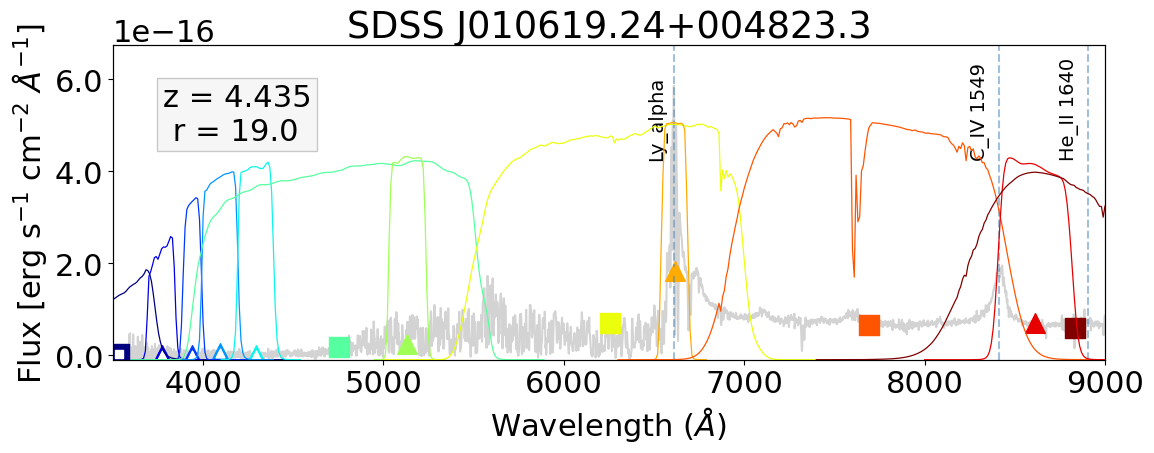

In [127]:
for id, row in subset.iterrows():
    print(id, row.Z, row.Field, row.RA_1, row.DEC_1)
    plot_SED(row, save=True)
    # plot_SED_aper(row)